# Aerated Bioreactor Design for Oleochemical Production

The oleochemical industry is focusing renewable feedstocks and more sustainable pathways of production. Microbial pathways are generally not market competitive for the production of commodity oleochemicals, but technological breakthroughs in metabolic engineering are making microbial pathways a promising platform. In this case study, we discuss how to model an aerobic fermentation system for producing microbial oil, which can be further upgraded to sustainable aviation fuel or other oleochemicals. The aerobic fermentation system (including the compressor, reactor, agitator, and heat exchange equipment) constitutes the major cost driver in the minimum oil selling price.

The goals of this case study are to:
* Understand the design basis of sizing an aerated bioreactor in BioSTEAM.
* Put in practice BioSTEAM's design algorithms for microbial oil production.
* Leverage senstivity analysis for uncovering key economic drivers. 

## Design basis

### Configuration

In this case study, we implement an industry-relevant configuration consisting of a stirred tank reactor, a heat exchanger loop, and a compressor (Figure 1). If you feedstock is in the form of diluted sugars (e.g., lignocellusic hydrolysate), you may need to concentrated your feed to achieve the a specified titer. This can be done efficiently through multi-effect evaporation, whereby the steam from the first effect is used to boil the next effect using a vacuum system. Alternatively, if you wish to operate at lower titers, you can dilute the sugars. Here we include both possibilities to be able to evaluate a spectrum of titers. Due to the high risk of bacterial contamination, we choose to operate in batch mode. Fed-batch configurations are also possible and can be modeled in a similar fashion. 

![Aerated bioreactor configuration](aerated_bioreactor_configuration.svg)

### Mass transfer and mixing

Aerobic processes demand an oxygen uptake rate (OUR) which is satisfied by the oxygen transfer rate (OTR) under quasi steady-state. The basic mass tranfer equation is:

$$ OTR = k_La(C_{out} - C) $$

For tall vessels (>1 m tall) the log-mean driving force is more accurate. Due to the oxygen partial pressure gradient, the local concentration and the saturation concentration are different at the top and bottom of the reactor:

$$ OTR = k_La \frac{(C_{sat} - C)_{out} - (C_{sat} - C)_{in}}{ln\Big(\large \frac{(C_{sat} - C)_{out}}{(C_{sat} - C)_{in}} \Big)} $$

The $k_La$ can be correlated to the superficail gas velocity, $U_S$, and the agitator power per unit volume, $P$, as follows:

$$ k_La = AP^BU_S^C $$

Where A, B, and C are correlation coefficients dependent on the agitator system, broth type, and size dimensions. The detailed design of the agitator is not relevant at this stage of the analysis, but the correlation coefficients will be a function of the agitator design.

**Assumptions**

* Assume a dissolved oxygen concentration of 50% saturation. Note that the flow rate of air (or agitation power) required to achieve an oxygen uptake rate equal to the oxygen transfer rate will depend on the oxygen saturation.
* Set the power consumed by the agitator to 0.985 kW∙m3, a heuristic value common for industrial homogeneous reactions and comparable to estimates in Aspen plus. Note that is also possible to minimize power consumption by varying flow rate, but this would also lead to a greater capital cost for the compressor.
* Assume the Van't Riet’s non-viscous mass transfer correlation is applicable to estimate the overall mass transfer coefficient, kLa (lumped together with the specific interfacial area). 

In [1]:
theta_O2 = 0.5 # Dissolved oxygen concentration [% saturation]
agitation_power = 0.985 # [kW / m3]
kLa_coefficients = "Van't Riet" # Name of method

### Heat transfer

The heat exchanger loop provides additional mixing with the trade-off of temperature gradients throughout the loop. The fluid at the inlet of the heat exchanger is at the reactor operating temperature while the outlet fluid will be at a lower temperature, which depends on the flow rate. We can specify the outlet temperature (which cannot be too low to avoid inactivation of the yeast) and solve for the recirculation flow rate:

$$F = \frac{Duty}{C_pT_{outlet} - C_pT_{inlet}} $$

The detailed design of the heat exchanger follows by-the-book design and consting algorithms, but is not discussed here.

**Assumptions**

* The fermentation temperature is 32 $^\circ$C
* Assume the temperature of the heat exchanger outlet does not drop by more than 8 $^\circ$C
* Assume the aerobic fermenter has a high heat-production rate of 110 kcal per mol of O2 consumed.

In [2]:
T_operation = 273.15 + 32 # [K]
Q_O2_consumption = -110 * 4184 # [kJ/kmol]
dT_hx_loop = 8 # degC

## Compressor

The compressor is needed to pressurize air to make up for the liquid head and losses from the sparger ring and piping. Currently, BioSTEAM only accounts for the liquid head. The outlet from the compressor has an increased temperature due to thermodynamic inefficiencies. For this reason, a cooler is also needed to brin the temperature back down.

### Reaction stoichiometry

The production of microbial oil is an aerobic process that can be modeled as the sum of 3 stoichiometric reactions: oil production from sugar, combustion of glucose (respiration), and cell growth. The substrate not converted to cell mass or oil is assumed to be consumed for respiration. Given the yield of triolein, Yp (wt %), and the fraction of biomass produced over the total substrate not consumed for oil production, Yb (wt %,), the extent of each reaction can be calculated. 

| Reaction            | Stoichiometry (by mol)                                             | Reaction extent               |
| ------------------- | ------------------------------------------------------------------- | ----------------------------- |
| Production:         | $$ Glucose \rightarrow 0.235\ H_2O + 2.53\ O_2  + 0.118\ Tripalmitin $$ | $$ X_p=\frac{Y_p}{0.527}   $$ |
| <sup>a</sup>Growth: | $$ Glucose \rightarrow 1.7\ H_2O + 0.655\ CO_2 + 5.35\ Yeast      $$ | $$ X_b= (1-X_p ) \cdot Y_b $$ |
| Respiration:        | $$ Glucose + 6 O_2 \rightarrow 6 H_2O + 6 CO_2                    $$ | $$ X_r=1-X_p-X_b           $$ | 

<center><sup>a</sup>The molecular formula of yeast is assumed to be $CH_{1.61}O_{0.56}$</center>

**Assumptions**

* The maximum volume of each reactor vessel is 200 $\text{m}^\text{3}$.
* Titer is 27.4 g∙L<sup>-1</sup>
* Productivity is 0.31 g∙L<sup>-1</sup>∙h<sup>-1</sup> 
* Yield is 18 wt %
* Ratio of biomass produced over total substrate not consumed for oil production is 43 wt %

In [3]:
V_max = 200 # [m3]
titer = 27.4 # [g / L]
productivity = 0.31 # [g / L / h]
lipid_yield = 0.18 # [by wt]
Y_b = 0.43 # [by wt]

## Bioreactor modeling in BioSTEAM

With an introductory understanding of the design principles, we can now model our configuration. The first step we will take is to create the chemicals and formulate the reactions:

In [4]:
import biosteam as bst
bst.nbtutorial()
bst.settings.set_thermo([
    bst.Chemical('Glucose', phase='l'),
    bst.Chemical('Water'),
    bst.Chemical('CO2'),
    bst.Chemical('O2'),
    bst.Chemical('N2'),
    bst.Chemical('Tripalmitin', phase='l', Hf=-2468.7),
    bst.Chemical('Yeast', 
        phase='s',
        search_db=False,
        formula='CH1.61O0.56',
        rho=1540, # kg/m3
        Cp=1.5, # J/g
        default=True, # Default other properties
    )
])
chemicals = bst.settings.chemicals
chemicals.set_alias('Tripalmitin', 'Lipid')
chemicals.set_alias('Tripalmitin', 'lipid')
chemicals.set_alias('Yeast', 'cellmass')
chemicals.Lipid.V.method = 'HTCOSTALD'
production = bst.Reaction(
    "Glucose -> H2O + O2 + Lipid", reactant='Glucose', X=1,
    correct_atomic_balance=True,
)
production.product_yield('Lipid', basis='wt', product_yield=lipid_yield)
growth = bst.Reaction(
    'Glucose -> H2O + CO2 + Yeast', 'Glucose', 1, 
    correct_atomic_balance=True
)
growth.product_yield('Yeast', basis='wt', product_yield=Y_b)
respiration = bst.Reaction(
    'Glucose + O2 -> CO2 + H2O', 'Glucose', 1. - growth.X,
    correct_atomic_balance=True
)
reactions = bst.ReactionSystem(
    production,
    bst.ParallelReaction([growth, respiration])
)
reactions.show()

ReactionSystem:
[0]  Reaction (by mol):
     stoichiometry                                         reactant    X[%]
     Glucose -> 0.235 Water + 2.53 O2 + 0.118 Tripalmitin  Glucose    34.14
[1]  ParallelReaction (by mol):
     index  stoichiometry                                  reactant    X[%]
     [0]    Glucose -> 1.7 Water + 0.655 CO2 + 5.35 Yeast  Glucose    64.15
     [1]    Glucose + 6 O2 -> 6 Water + 6 CO2              Glucose    35.85


Now let's create our aerated bioreactor:

In [5]:
effluent = bst.Stream('effluent')
AB1 = bst.AeratedBioreactor('AB1',
    ins=['feed', bst.Stream('air', phase='g')],
    outs=['vent', effluent],
    V_max=V_max, Q_O2_consumption=Q_O2_consumption,
    dT_hx_loop=dT_hx_loop, T=T_operation,
    batch=True, reactions=reactions,
    kW_per_m3=agitation_power,
    tau=titer/productivity,
    optimize_power=False,
)

performance = {
    'titer': titer,
    'productivity': productivity,
    'yield': lipid_yield,
}

@AB1.add_specification(run=True)
def update_reaction_time_and_yield():
    AB1.tau = performance['titer'] / performance['productivity']
    production.product_yield('Lipid', basis='wt', product_yield=performance['yield'])

AB1.diagram()

The bioreactor system already comes with all the auxiliary units for aeration and heat transfer. All what is left is to add the concentration/dilution system along with an oil recovery system. We create the multi-effect evaporator assuming 5 effects. The required vapor fraction of the first effect will be solved for in a specification. We will leverage a pre-made system for mechanical microbial oil recovery:

In [6]:
from flexsolve import wegstein as itersolve
from biorefineries.cane.systems import create_lipid_extraction_system

feedstock = bst.Stream('feedstock',
    Water=0.85, Glucose=0.15, 
    total_flow=1e5, units='kg/hr',
    price=0.14 * 0.15,
)
E1 = bst.MultiEffectEvaporator('E1',
    ins=feedstock, outs=('evaporated_feed', 'condensate'), 
    V=0, V_definition='First-effect',
    P=(101325, 73581, 50892, 32777, 20000),
)
dilution_water = bst.Stream('dilution_water')
M1 = bst.Mixer('M1',
    ins=(E1-0, dilution_water), outs=AB1.ins[0]
)

def get_titer(): # g/L or kg/m3
    product_mass_flow = effluent.imass['Lipid'] # effluent.get_flow('kg / hr', 'lipid')
    volumetric_flow_rate = effluent.F_vol # effluent.get_total_flow('m3/hr')
    return product_mass_flow / volumetric_flow_rate

def adjust_dilution_water(water):
    dilution_water.imass['Water'] = water
    E1.run_until(AB1, inclusive=True)
    target = performance['titer']
    current = get_titer()
    rho = chemicals.Water.rho('l', T=T_operation, P=101325) # kg / m3
    return water + (1./target - 1./current) * effluent.imass['Lipid'] * rho
    
@E1.add_bounded_numerical_specification(x0=0, x1=0.15, ytol=1e-3, xtol=1e-6, maxiter=20)
def evaporation(V):
    E1.V = V
    if V == 0: 
        needed_water = itersolve(adjust_dilution_water, 0, xtol=1)
        if needed_water > 0: return performance['titer'] - get_titer()
    dilution_water.empty()
    E1.run_until(AB1, inclusive=True)
    return performance['titer'] - get_titer()

lipid_extraction_sys = create_lipid_extraction_system(ins=effluent)
# Optimistic price for defatted biomass; https://doi.org/10.1186/s13068-021-01911-3
lipid_extraction_sys.get_outlet('cellmass').price = 0.5 * 0.68
# microbial_lipids_sys = bst.main_flowsheet.create_system('microbial_lipids_sys')
microbial_lipids_sys = bst.System.from_units(
    'microbial_lipids_sys', 
    units=[E1, M1, AB1, *lipid_extraction_sys.units]
)
microbial_lipids_sys.simulate()
microbial_lipids_sys.diagram(auxiliaries=True)

With our system complete, let's proceed to perform TEA using the same preliminary assumptions used in Humbird's 2011 report for cornstover ethanol: 

In [7]:
from biorefineries.tea import create_cellulosic_ethanol_tea
microbial_lipids_tea = create_cellulosic_ethanol_tea(microbial_lipids_sys)
lipid_product = lipid_extraction_sys.get_outlet('lipid')
microbial_lipids_tea.solve_price(lipid_product)

2.0200496294072674

Now that we have a working model, let's leverage it to evaluate a landscape of potential fermentation scenarios:

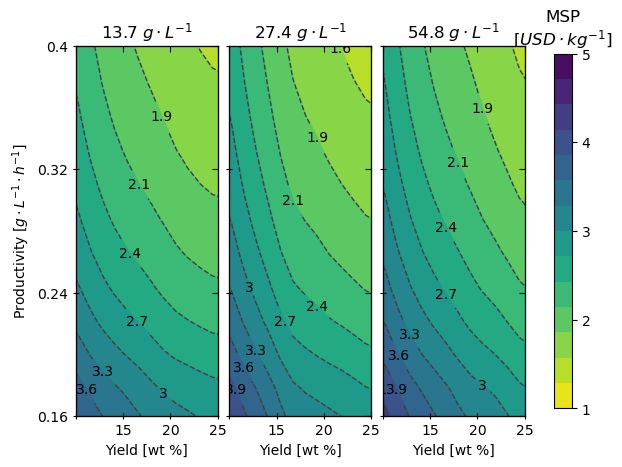

In [8]:
import numpy as np
from matplotlib import pyplot as plt

def MSP_at_yield_productivity_titer(lipid_yield, productivity, titer):
    performance['yield'] = lipid_yield
    performance['productivity'] = productivity
    MSP = np.zeros_like(titer)
    for i, value in enumerate(titer):
        performance['titer'] = value
        microbial_lipids_sys.simulate()
        MSP[i] = microbial_lipids_tea.solve_price(lipid_product)
    return MSP

titer = np.array([
    0.5 * titer,
    titer,
    2 * titer,
])
xlim = np.array([0.5 * lipid_yield, 1.5 * lipid_yield])
ylim = np.array([0.5 * productivity, 1.5 * productivity])
X, Y, Z = bst.plots.generate_contour_data(
    MSP_at_yield_productivity_titer,
    xlim=xlim, ylim=ylim,
    args=(titer,),
    n=15,
)

# Plot contours
xlabel = "Yield [wt %]"
ylabel = 'Productivity [$g \cdot L^{-1} \cdot h^{-1}$]'
units = r'$g \cdot L^{-1}$'
titles = [f"{round(i, 2)} {units}" for i in titer]
xticks = [10, 15, 20, 25]
yticks = [0.16, 0.24, 0.32, 0.40]
metric_bar = bst.plots.MetricBar(
    'MSP', '$USD \cdot kg^{-1}$', plt.cm.get_cmap('viridis_r'), 
    bst.plots.rounded_tickmarks_from_data(Z, 5, 1, expand=0, p=0.5), 15, 1
)
fig, axes, CSs, CB, other_axes = bst.plots.plot_contour_single_metric(
    100 * X, Y, Z[:, :, None, :], xlabel, ylabel, xticks, yticks, metric_bar,  
    titles=titles, fillcolor=None, styleaxiskw=dict(xtick0=False), label=True,
)

As expected, the yield and productivity are impactful but not the titer.